In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [12]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education = pd.read_sql_query('select * from useducation',con=engine)

engine.dispose()

In [13]:
fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = education["STATE"].unique()

for state in states:
    education.loc[education["STATE"] == state, fill_list] = education.loc[education["STATE"] == state, fill_list].interpolate()

education.dropna(inplace=True)

### 1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!

In [26]:
education['total_score'] = ((education['GRADES_4_G'] * ((education['AVG_MATH_4_SCORE'] + education['AVG_READING_4_SCORE'])*0.5)) + (education['GRADES_8_G'] * ((education['AVG_MATH_8_SCORE'] + education['AVG_READING_8_SCORE'])*0.5))) / (education['GRADES_4_G'] + education['GRADES_8_G'])

education.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,total_score
209,1996_ALABAMA,ALABAMA,1996,735912.0,3365113.0,334858.0,2138717.0,891538.0,3572283.0,1987018.0,...,58305.0,42510.0,469370.0,207980.0,686983.0,211.646974,256.594863,210.920767,260.276441,235.106342
211,1996_ARIZONA,ARIZONA,1996,764681.0,4143304.0,378917.0,1798363.0,1966024.0,4391555.0,1860007.0,...,60514.0,42041.0,511925.0,210289.0,726709.0,217.575940,267.874834,206.529788,263.283638,238.321404
212,1996_ARKANSAS,ARKANSAS,1996,452907.0,2183384.0,192152.0,1296247.0,694985.0,2297381.0,1264275.0,...,37064.0,27613.0,283883.0,131997.0,417860.0,215.846436,261.652745,208.837716,271.834590,240.773675
213,1996_CALIFORNIA,CALIFORNIA,1996,5460484.0,31282981.0,2603882.0,17061474.0,11617625.0,31561692.0,16880730.0,...,406456.0,298669.0,3516572.0,1525618.0,5115423.0,209.129083,262.772478,201.912591,269.197451,234.719834
214,1996_COLORADO,COLORADO,1996,655679.0,3891203.0,194998.0,1664676.0,2031529.0,4075165.0,2052264.0,...,52269.0,37179.0,423510.0,185700.0,621730.0,225.805858,275.608214,221.653243,268.168154,247.750273


### 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [30]:
education[["total_score", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()

,total_score,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
total_score,1.000000,0.074155,0.087386,0.079002,0.010959,-0.005389
TOTAL_EXPENDITURE,0.074155,1.000000,0.990255,0.992988,0.943702,0.925784
INSTRUCTION_EXPENDITURE,0.087386,0.990255,1.000000,0.974399,0.902173,0.884798
SUPPORT_SERVICES_EXPENDITURE,0.079002,0.992988,0.974399,1.000000,0.952282,0.911245
OTHER_EXPENDITURE,0.010959,0.943702,0.902173,0.952282,1.000000,0.918188
CAPITAL_OUTLAY_EXPENDITURE,-0.005389,0.925784,0.884798,0.911245,0.918188,1.000000


Instruction expenditure is the most correlated to the total score variable, but it is a weak correlation at only 0.0874. 

### 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component? 

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = education[["INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
education["PCA_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by the top component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by the top component from Sklearn PCA.
 [0.9430175]


The first component explains more than 94 percent of the total variance. 

### 4. What is the correlation between the overall score variable and the 1st principal component?

In [31]:
education[["PCA_1", "total_score"]].corr()

,PCA_1,total_score
PCA_1,1.000000,0.044596
total_score,0.044596,1.000000


The correlation between first principle component and total score variable is 0.0446, which is less than three of the expenditure variables. 

### 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

   If I were to choose variables for a model I would choose the expenditure variables, however I don't think either would be a wise choice. There are three expenditure variables that are more highly correlated with the total score than the PCA variable is (but they are all very close to 0) which is why I would make this choice. PCA works best for normally distributed data, and we see below from the histogram that the expenditure features are not normally distributed. If we took care of this, perhaps PCA would be the better choice. Additionally, as mentioned above the correlation between the 1st principal component and total score variable is close to 0, meaning there is little shared information. On the other hand, since the expenditure variables are all highly correlated with each other this can cause unstable solutions in a model using the these variables.

Text(0.5, 1.0, 'Total Expenditure')

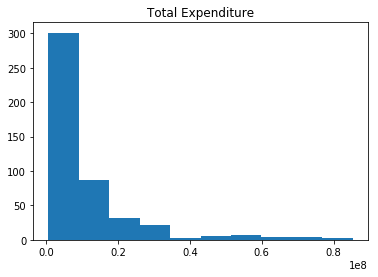

In [35]:
plt.hist(education['TOTAL_EXPENDITURE'])
plt.title("Total Expenditure")